## Импорты

In [ ]:
import pandas as pd
import numpy as np
import random
import re
import string
import itertools
from tqdm import tqdm
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["grey", "#e94cdc", "blue", "orange"]) 

random.seed(1)
SEED = 1

In [ ]:
#!python -m spacy download en_core_web_lg
#restart runtime after this

In [ ]:
import spacy
nlp = spacy.load('en_core_web_lg')

import nltk
nltk.download('punkt')
from nltk import word_tokenize, sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# REALEC data

In [ ]:
!wget https://raw.githubusercontent.com/yuagorshkova/realec_lexical_error_correction/main/realec_lexical_errors.csv

--2022-05-26 20:53:39--  https://raw.githubusercontent.com/yuagorshkova/realec_lexical_error_correction/main/realec_lexical_errors.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3336235 (3.2M) [text/plain]
Saving to: ‘realec_lexical_errors.csv’

realec_lexical_erro 100%[===================>]   3.18M  --.-KB/s    in 0.07s   

2022-05-26 20:53:39 (45.1 MB/s) - ‘realec_lexical_errors.csv’ saved [3336235/3336235]



In [ ]:
data = pd.read_csv('realec_lexical_errors.csv')
data.rename(columns={c:c.lower() for c  in data.columns}, inplace=True)
print(f"Number of objects: {data.shape[0]}")
data.sample(5, random_state=SEED)

Number of objects: 17055


,text_name,error_type,error_span,correction,error_sentence
5726,2016_EKu_23_1.txt,"Change, addition, deletion of a part of colloc...",kind,kind of,The line graph illustrates the information abo...
13902,2017_OBy_52_2.txt,Choice of lexical item,illness,diseases,"Overall, human have not reduced illness before..."
4161,2014_TSha_10_1.txt,Choice of lexical item,amount,the percentage,Then we can see that amount of people aged 65 ...
9119,2017_DOv_4_1.txt,Choice of lexical item,reveals,displays,The graph reveals information about proportion...
15656,2019_ABu_224_2.txt,Choice of lexical item,create,develop,"Furthermore, the children who have just starte..."


## Duplicates

In [ ]:
len_before = data.shape[0]
data.drop_duplicates(keep='first', inplace=True)
print(f"Dropped {len_before - data.shape[0]} rows, {data.shape[0]} left")

Dropped 120 rows, 16935 left


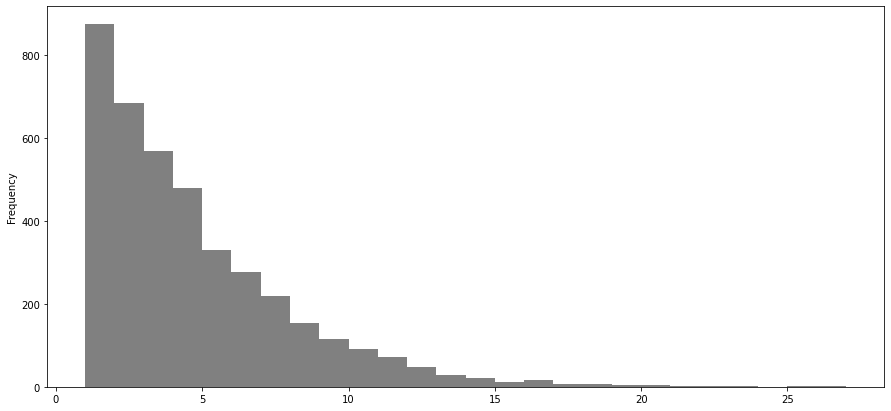

In [ ]:
plt.figure(figsize=(15,7))

data_value_counts = data.text_name.value_counts()
data_value_counts.plot(kind='hist', 
                       bins=np.unique(data_value_counts).shape[0])

plt.show()

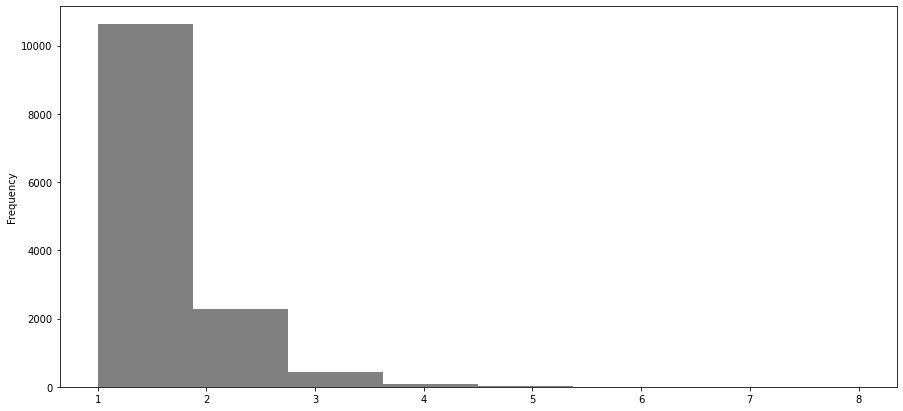

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['sentence_id'] = le.fit_transform(data['error_sentence'])

plt.figure(figsize=(15,7))
data_value_counts = data['sentence_id'].value_counts()
data_value_counts.plot(kind='hist', 
                       bins=np.unique(data_value_counts).shape[0])

plt.show()

In [ ]:
error_spans_per_sentence = data.groupby(['sentence_id', 'error_span']).size()
error_spans_per_sentence = pd.DataFrame(error_spans_per_sentence)
error_spans_per_sentence.sample(2)

,,0
sentence_id,error_span,
2288,was,1
2101,than,1


In [ ]:
same_span_several_errors = data.groupby(['sentence_id', 'error_span']).size()
data['same_span_several_errors'] = data[['sentence_id', 'error_span']].apply(lambda x: error_spans_per_sentence.loc[x.values[0]].loc[x.values[1]], axis=1)
data['same_span_several_errors'].value_counts()

1    16741
2      188
3        6
Name: same_span_several_errors, dtype: int64

In [ ]:
# В первом случае исправляются разные слова, во втором были разные разметчики
pd.options.display.max_colwidth = 120
data[data['same_span_several_errors'] == 3][['error_span', 'correction', 'error_sentence']].head(15)

,error_span,correction,error_sentence
15425,you,somebody,"That means, if you have money, you can have any service, any product or any thing that you could wish for."
15426,you,he or she,"That means, if you have money, you can have any service, any product or any thing that you could wish for."
15427,you,person,"That means, if you have money, you can have any service, any product or any thing that you could wish for."
16274,shares,percentage,In 1995 the trend of level of obesity among both children levelled off and reached the same shares (nearly 15%).
16275,shares,level,In 1995 the trend of level of obesity among both children levelled off and reached the same shares (nearly 15%).
16276,shares,level,In 1995 the trend of level of obesity among both children levelled off and reached the same shares (nearly 15%).


In [ ]:
#в основном разыне разметчики
data[data['same_span_several_errors'] == 2][['error_span', 'correction', 'error_sentence']].head(15)

,error_span,correction,error_sentence
431,are,consisted of,"The number of this people are 21303 and the small group in this sector are people from 56 to 65 years, this fact ill..."
432,are,was made up by,"The number of this people are 21303 and the small group in this sector are people from 56 to 65 years, this fact ill..."
675,amount,the highest proportion,While amount of male firstly has spent 90 percent.
676,amount,proportion,While amount of male firstly has spent 90 percent.
680,Undergraduate diploma,undergraduate diploma holders,Undergraduate diploma was just less half past from all percentage.
681,Undergraduate diploma,the number of undergraduate diploma holders,Undergraduate diploma was just less half past from all percentage.
1098,peck,peak,"The curve heats a peck 25%, and heats a low approximately in 7%."
1099,peck,peak of,"The curve heats a peck 25%, and heats a low approximately in 7%."
1351,is,with,The one which is in London was opened in 1863 and is 394 kilometers while the one in Paris which was opened in 37 ye...
1352,is,has,The one which is in London was opened in 1863 and is 394 kilometers while the one in Paris which was opened in 37 ye...


In [ ]:
# в общем я хочу дропнуть эти примеры....
len_before = data.shape[0]

indices_to_drop = data[data['same_span_several_errors'] == 2].index
data.drop(index = indices_to_drop, inplace=True)
print(f"Dropped {len_before - data.shape[0]} rows, {data.shape[0]} left")

Dropped 188 rows, 16747 left


## Target

In [ ]:
data1 = data.copy()
data = data1.copy().reset_index(drop=True)
#drop if not latin

In [ ]:
data.fillna('', inplace=True)
data.head(5)

,text_name,error_type,error_span,correction,error_sentence,sentence_id,same_span_several_errors
0,2014_AAl_10_1.txt,Choice of lexical item,incline,increase,"After a stable period, we see a huge incline that would occur in Japan from 2020 to 2040.",253,1
1,2014_AAl_10_1.txt,Choice of lexical item,old,elderly,"USA, however, had bigger part of old people throughout the century, having 10% in 1960 and even 15% in 1980, but the...",12842,1
2,2014_AAl_10_1.txt,Word choice,Sweden chart,The graph for Sweden,"Sweden chart is almost equal to the US one, only big discrepancy is 20% in 2020 in Sweden versus below 15% in the US.",9454,1
3,2014_AAl_10_1.txt,Choice of lexical item,visualize,demonstrates,"Given diagram visualize the proportion of population aged 65 and over in Japan, Sweden and the United States from 19...",3487,1
4,2014_AAl_10_1.txt,Choice of lexical item,part,percentage,"USA, however, had bigger part of old people throughout the century, having 10% in 1960 and even 15% in 1980, but the...",12842,1


#### parentheses

In [ ]:
def regex_bool(regexp, text):
  return bool(re.search(regexp, text))

def make_re(text):
  return '[' + '\\'.join(list(text)) + ']'

PARENTHESES = list('()[]{}<>')
PARENTHESES_RE = make_re(PARENTHESES)

indices_where_parentheses = np.where(data['correction'].apply(lambda x: regex_bool(PARENTHESES_RE, x)))[0]
data.iloc[indices_where_parentheses]

,text_name,error_type,error_span,correction,error_sentence,sentence_id,same_span_several_errors
361,2014_ADe_11_2.txt,Choice of lexical item,enable,let (OR make) their children,It is a parents business to decide when they should enable their children to learn foreign language.,5809,1
1002,2014_ASt_38_1.txt,Choice of lexical item,amount,number (words often confused),"On contrary, the most significant amount of passengers is registered in Paris and Tokyo with 1191 and 1927 million o...",7543,1
3898,2014_MTsy_21_2.txt,Word choice,for money,for (the sake of) making money,"sportsmen motivate a lot of people to go to gym or sections to be healthier and stronger, to be the best, and not do...",13404,1
4837,2014_ZEv_11_1.txt,Word choice,second,next(?),The second two popular countries are Spain and USA which met 9 and 4 million. of tourists from England respectively.,11107,1
6718,2016_MTsy_7_1.txt,Choice of lexical item,such as boys and girls,(boys as well as girls),"It is immediately clear from the graph, that all numbers of children such as boys and girls, declined from 2000 to 2...",5976,1
10516,2017_EGe_98_1.txt,Choice of lexical item,many billion of dollars,much money (in billion dollars),"This bar chat presents the data on how many billion of dollars were spent on print and eBook market in the USA, Germ...",11952,1


In [ ]:
def delete_parentheses_in_correction(text):
  return re.sub(' ?\(.*\)', '', text)

def replace_parentheses(text):
  return re.sub(' ?[\(\)] ?', ', ', text)

data['correction'] = data['correction'].apply(lambda x: delete_parentheses_in_correction(x))

data['error_span'] = data['error_span'].apply(lambda x: replace_parentheses(x))

#### symbols

In [ ]:
SYMBOLS = ('$^*^~?')
SYMBOLS_RE = make_re(SYMBOLS)

indices_where_symbols = np.where(data['correction'].apply(lambda x: regex_bool(SYMBOLS_RE, x)))[0]
data.iloc[indices_where_symbols].sample(6)

,text_name,error_type,error_span,correction,error_sentence,sentence_id,same_span_several_errors
996,2014_ASt_35_2.txt,Word choice,picture,?,"Summing up, I am absolutely do not agree that our picture mostly depends on our characteristics from birth.",9436,1
3849,2014_MTsy_17_2.txt,Word choice,many,many/most of them?,"The truth is that a lot of people are too busy or lazy to visit gyms and do sports, so many would prefer to stop smo...",11241,1
5640,2016_EKu_26_2.txt,Word choice,driven,?,"This correlation is driven by our understanding of justice and, therefore, depends on local laws and cultural differ...",11979,1
3959,2014_MTsy_32_1.txt,Word choice,very few,scarce?,People who are older than 60 years are very few.,8395,1
16349,2019_EEr_147_2.txt,Choice of lexical item,raws,???,"To start with, the rows of typical buildings may influence negatively the emotional state of people.",12497,1
5940,2016_JSl_153_1.txt,Choice of lexical item,investment,bn $,The lowest level of investment in developing countries was in 2006 year just round 25 investment.,10448,1


In [ ]:
data = data.drop(index = indices_where_symbols).reset_index(drop=True)

#### options

In [ ]:
SLASH_RE = '[/\\\]'

indices_where_slash = np.where(data['correction'].apply(lambda x: regex_bool(SLASH_RE, x)))[0]
data.iloc[indices_where_slash].sample(6)

,text_name,error_type,error_span,correction,error_sentence,sentence_id,same_span_several_errors
7702,2016_ZEv_29_2.txt,Choice of lexical item,spread,widespread/popular/common,"Thus, there is a spread point of view that the number of flights should be controlled by the authorities.",12227,1
1054,2014_ASt_42_2.txt,Word choice,work with brains,to make an intellectual work/ brainwork,"In comparison of first opinion, the second was more power, because a person, who wont work with brains, who will hav...",4799,1
377,2014_ADe_13_2.txt,Choice of lexical item,prepared,thought of / studied,One of the most important things that should be prepared is the foreign language.,7906,1
2590,2014_EPa_8_2.txt,Choice of lexical item,undoubtless,undoubted // doubtless,It is undoubtedly that increasing the number of sports facilities is excellent way to improve public health.,6149,1
3959,2014_MTsy_33_2.txt,Word choice,having,doing/taking up,This tendency will have a good effect on public health if people really understand the pluses of having a sport acti...,12161,1
886,2014_ASt_20_2.txt,Choice of lexical item,qualities,personality/ features,It is believed that our qualities that we have from the moment when we are born play the most significant role in ou...,5853,1


In [ ]:
def choose_correction(text):
  if  not ('\\' in text or '/' in text):
    return(text)
  else:
    if '\\' in text:
      options = text.split('\\')
    elif '/' in text:
      options = text.split('/')
    options_lens = [len(o.split(' ')) for o in options]
    if max(options_lens) == 2:
      return options[options_lens.index(2)]
    elif max(options_lens) > 2:
      return ' '.join(options[0].split()+options[1].split()[1:])
    elif len(set(options_lens)) == 1:
      return options[0]
    return ''

data['correction'] = data['correction'].apply(lambda x: choose_correction(x))


#### wrong span

In [ ]:
def span_not_in_sent(span, sent):
  return span.lower() not in sent.lower()

incorrect_span_indices = np.where(data[['error_span', 'error_sentence']].apply(lambda x: span_not_in_sent(*x), axis=1))[0]
data.iloc[incorrect_span_indices]

,text_name,error_type,error_span,correction,error_sentence,sentence_id,same_span_several_errors
11,2014_AAl_11_1.txt,Choice of lexical item,diagramm,the graph,It should be mentioned that diagram shows great increase of the population aged 65 and over in short period of time ...,6269,1
30,2014_AAl_12_2.txt,Choice of lexical item,destlict,deprive,"For instance, if we deprive someone in their right for higher education it can cause the termination of woman develo...",3120,1
39,2014_AAl_13_1.txt,Choice of lexical item,then,than,"However, the economic situation has not always been so brilliant, moreover, it was much worse there than in Europe a...",3834,1
46,2014_AAl_15_1.txt,Choice of lexical item,was continning,remained as such,The graph also shows that the lowest proportion of population aged 65 and over in USA and Sweden was in 1940 while t...,10165,1
65,2014_AAl_18_1.txt,Choice of lexical item,fastly,sharply,After this point the population of elder people in Japan is surely rising up to ten percent in 2030 and fast increas...,300,1
...,...,...,...,...,...,...,...
16692,2019_EEr_34_1.txt,"Change, addition, deletion of a part of collocation",did sport excersises,did exercises,"And we also have a table, which shows how much kids did sport exercise exercise in years 1990 and 2005.",903,1
16707,2019_EEr_77_2.txt,Choice of lexical item,adress,address,"Personally, I believe that both parents and school are equally important and prominent in nurturing children as they...",8457,1
16710,2019_EEr_93_2.txt,Choice of lexical item,posess,have,"As soon as they create an account in social networks, they start to posses a wealth of friends from all over the wor...",1293,1
16726,2019_EEr_99_2.txt,Choice of lexical item,beginnig,origin,"Those two skills are standing very close to each other, which proves the art beginning of the architecture.",12182,1


In [ ]:
data = data.drop(index = incorrect_span_indices).reset_index(drop=True)

#### preprocess

In [ ]:
#диакритика?
def preprocess_text(text):
  text = text.lower()
  text = text.replace('%', ' percent ')
  text = text.replace('+', ' plus ')
  text = re.sub(r'  +', ' ', text)
  return text

data.fillna('', inplace=True)
data['error_span'] = data['error_span'].apply(lambda x: preprocess_text(x))
data['correction'] = data['correction'].apply(lambda x: preprocess_text(x))
data['error_sentence'] = data['error_sentence'].apply(lambda x: preprocess_text(x))

In [ ]:
data['error_correction_pair'] = data[['error_span', 'correction']].apply(lambda x: tuple(x), axis=1)

data_final = data.groupby(['sentence_id']).agg({'error_sentence': lambda x: list(x)[0], 
                                   'error_correction_pair': list}).reset_index()
data_final.head()

,sentence_id,error_sentence,error_correction_pair
0,0,"""agriculture"" in indonesia is in the middle place and the last one is under ""industry"" control.","[(middle, second)]"
1,1,"""mother should take care of her own child at first"", by this quote we simply can see that problems of government's o...","[(on the first position, in the first place)]"
2,2,(12 million visitors) the second country was spain with 9 million british residents.,"[(residents, holiday-makers)]"
3,3,(in 2020 it became 13 percent ).,"[(became, will be)]"
4,4,"(the destination between moscow and saint petersburg, for instance, can be easily overcame by ""lastochka"" train for ...","[(destination, distance)]"


#### Create Target

In [ ]:
def strings_intersect(s1, s2):
  return len(set(s1.split(' ')) & set(s2.split(' '))) > 0
def mult_strings_intersect(*args):
  return [(i1, i2) for i1,i2 in itertools.combinations(range(len(args)), 2) if strings_intersect(args[i1], args[i2])]
def errors_intersect(row):
  errors = list(zip(*row))[0]
  check = mult_strings_intersect(*errors)
  if len(check) >0:
    return check
  else:
    return None

def choose_errors(row, intersections):
  intersecting_errors = list(set(sum(intersections, ())))
  not_intersecting = list(set(range(len(row))) - set(intersecting_errors))
  errors = list(zip(*row))[0]
  errors_lens = [len(errors[i]) for i in intersecting_errors]
  chosen_error = intersecting_errors[np.argmax(errors_lens)]
  return [row[i] for i in sorted([chosen_error] + not_intersecting)]

def create_target(sentence, error_correction_pairs):
  corrected_sentence = sentence
  spans_before = []
  spans_after = []
  errors_intersection = errors_intersect(error_correction_pairs)
  if errors_intersection:
    pairs_to_correct = choose_errors(error_correction_pairs, errors_intersection)
  else:
    pairs_to_correct = error_correction_pairs
  for e, c in pairs_to_correct:
    if e in corrected_sentence:
      spans_before.append(re.search(e, corrected_sentence).span())
      corrected_sentence = re.sub(e, c, corrected_sentence, count=1)
      spans_after.append(re.search(c, corrected_sentence).span())
  return corrected_sentence, spans_before, spans_after


In [ ]:
data_final['temp'] = data_final[['error_sentence',	'error_correction_pair']].apply(lambda x: create_target(x[0], x[1]), 
                                                                                   axis=1)
data_final['corrected_sentence'] = data_final['temp'].apply(lambda x: x[0])
data_final['spans_before'] = data_final['temp'].apply(lambda x: x[1])
data_final['spans_after'] = data_final['temp'].apply(lambda x: x[2])
data_final = data_final.drop(columns='temp')
pairs = data_final['error_correction_pair'].tolist()
data_final = data_final.drop(columns='error_correction_pair')
data_final.head()

,sentence_id,error_sentence,corrected_sentence,spans_before,spans_after
0,0,"""agriculture"" in indonesia is in the middle place and the last one is under ""industry"" control.","""agriculture"" in indonesia is in the second place and the last one is under ""industry"" control.","[(37, 43)]","[(37, 43)]"
1,1,"""mother should take care of her own child at first"", by this quote we simply can see that problems of government's o...","""mother should take care of her own child at first"", by this quote we simply can see that problems of government's o...","[(144, 165)]","[(144, 162)]"
2,2,(12 million visitors) the second country was spain with 9 million british residents.,(12 million visitors) the second country was spain with 9 million british holiday-makers.,"[(74, 83)]","[(74, 88)]"
3,3,(in 2020 it became 13 percent ).,(in 2020 it will be 13 percent ).,"[(12, 18)]","[(12, 19)]"
4,4,"(the destination between moscow and saint petersburg, for instance, can be easily overcame by ""lastochka"" train for ...","(the distance between moscow and saint petersburg, for instance, can be easily overcame by ""lastochka"" train for 5 h...","[(5, 16)]","[(5, 13)]"


In [ ]:
X = data_final['error_sentence'].to_numpy()
y = data_final['corrected_sentence'].to_numpy()

X.shape, y.shape

((12773,), (12773,))

#### Drop sentences longer than 64 tokens

In [ ]:
token_len = lambda s: len(word_tokenize(s))
X_sentence_lens = np.array(list(map(token_len, X)))
y_sentence_lens = np.array(list(map(token_len, y)))

thr = 63
n_sent = X_sentence_lens.shape[0]
X_n = X_sentence_lens[X_sentence_lens > thr].shape[0]
y_n = y_sentence_lens[y_sentence_lens > thr].shape[0]
indices_to_drop = np.union1d(np.where(X_sentence_lens > thr)[0], 
                             np.where(y_sentence_lens > thr)[0])
together_n = indices_to_drop.shape[0]
print(f"# source sentences longer than {thr} words: {X_n}", " (%.2f percent)"%(100* X_n/n_sent))
print(f"# target sentences longer than {thr} words: {y_n}", " (%.2f percent)"%(100* y_n/n_sent))
print(f"# examples longer than {thr} words: {together_n}", " (%.2f percent)"%(100* together_n/n_sent))

# source sentences longer than 63 words: 59  (0.46 percent)
# target sentences longer than 63 words: 61  (0.48 percent)
# examples longer than 63 words: 62  (0.49 percent)


In [ ]:
X = np.delete(X, indices_to_drop)
y = np.delete(y, indices_to_drop)

X.shape, y.shape

((12711,), (12711,))

## Data Exploration 

In [ ]:
token_len = lambda s: len(word_tokenize(s))
X_sentence_lens = np.array(list(map(token_len, X)))
y_sentence_lens = np.array(list(map(token_len, y)))

len_diffs = X_sentence_lens - y_sentence_lens

In [ ]:
print(f'Source corpus len: {sum(X_sentence_lens)}')
print(f'Target corpus len: {sum(y_sentence_lens)}')

Source corpus len: 303877
Target corpus len: 304707


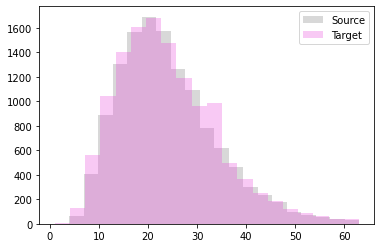

In [ ]:
plt.hist(X_sentence_lens, bins=20, alpha=0.3, label='Source')
plt.hist(y_sentence_lens, bins=20, alpha=0.3, label='Target')
plt.legend()
plt.show()

# words didnt't change in 62.04 percent of cases
# +-1 word change in 26.96 percent ofcases
# bigger change in 11.00 percent of cases


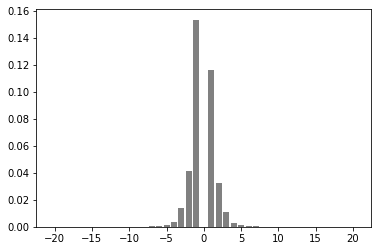

In [ ]:
unique, counts = np.unique(len_diffs[len_diffs!=0], return_counts=True)
counts = counts / len_diffs.shape[0]
print("# words didnt't change in %.2f percent of cases" % (100* len_diffs[len_diffs==0].shape[0] / len_diffs.shape[0]))
print("# +-1 word change in %.2f percent ofcases" % (100* len_diffs[abs(len_diffs) == 1].shape[0] / len_diffs.shape[0]))
print("# bigger change in %.2f percent of cases" % (100* len_diffs[abs(len_diffs) > 1].shape[0] / len_diffs.shape[0]))
plt.bar(unique, counts)
plt.show()

In [ ]:
data = pd.DataFrame({'source':X, 'target':y})
data.to_csv('realec_data.csv', index=False)

In [ ]:
data_final.drop(index = indices_to_drop, inplace=True)
data_final.reset_index(drop=True, inplace=True)
data_final.to_csv('alldata.csv', index=False)

In [ ]:
data_final

,sentence_id,error_sentence,corrected_sentence,spans_before,spans_after
0,0,"""agriculture"" in indonesia is in the middle place and the last one is under ""industry"" control.","""agriculture"" in indonesia is in the second place and the last one is under ""industry"" control.","[(37, 43)]","[(37, 43)]"
1,1,"""mother should take care of her own child at first"", by this quote we simply can see that problems of government's o...","""mother should take care of her own child at first"", by this quote we simply can see that problems of government's o...","[(144, 165)]","[(144, 162)]"
2,2,(12 million visitors) the second country was spain with 9 million british residents.,(12 million visitors) the second country was spain with 9 million british holiday-makers.,"[(74, 83)]","[(74, 88)]"
3,3,(in 2020 it became 13 percent ).,(in 2020 it will be 13 percent ).,"[(12, 18)]","[(12, 19)]"
4,4,"(the destination between moscow and saint petersburg, for instance, can be easily overcame by ""lastochka"" train for ...","(the distance between moscow and saint petersburg, for instance, can be easily overcame by ""lastochka"" train for 5 h...","[(5, 16)]","[(5, 13)]"
...,...,...,...,...,...
12706,13429,"which one associated with clearing an economy, growing benefits for dealers and increasing of motivation level among...","that one can include clearing an economy, growing benefits for dealers and increasing of motivation level among musi...","[(10, 25), (0, 5)]","[(10, 21), (0, 4)]"
12707,13430,"which rate was get a high in 2015, with 7,9 percent and become lower in 2014, it is now 7,5 percent .","which rate was get a high in 2015, with 7,9 percent and become lower in 2014, it became 7,5 percent .","[(81, 87)]","[(81, 87)]"
12708,13431,while only 6 percent of the last age group use it.,while only 6 percent of the latter age group use it.,"[(28, 32)]","[(28, 34)]"
12709,13432,"while the market of electronic books will see a slight increase - from 1 billion dollars in 2014 to 1,5 billion doll...","meanwhile the market of electronic books will see a slight increase - from 1 billion dollars in 2014 to 1,5 billion ...","[(0, 5)]","[(0, 9)]"


In [ ]:
pairs1 = list(itertools.chain(*pairs))
pairs1 = ((Counter(pairs1).most_common()))
error_corrections, ec_counts = list(zip(*pairs1))
ec_counts = np.array(ec_counts)

# Unique mistakes: 11492
# Mistakes encounetered once: 87.84 percent
# Mistakes encounetered twice: 6.96 percent


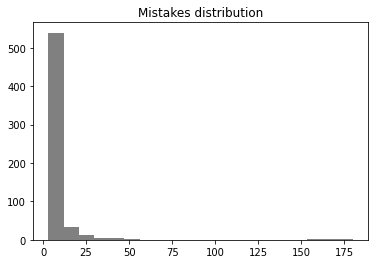

In [ ]:
print(f"# Unique mistakes: {len(error_corrections)}")
print(f"# Mistakes encounetered once: {round(100 *np.where(ec_counts == 1)[0].shape[0] / len(ec_counts), 2)} percent")
print(f"# Mistakes encounetered twice: {round(100 *np.where(ec_counts == 2)[0].shape[0] / len(ec_counts), 2)} percent")
plt.hist(ec_counts[ec_counts>2], bins=20)
plt.title('Mistakes distribution')
plt.show()

In [ ]:
for er, cor in error_corrections[:15]:
  print(f"{er} >> {cor}")

amount >> number
years >> years old
then >> than
percent >> percentage
quantity >> number
number >> percentage
another >> other
sport >> sports
than >> then
of >> 
which >> that
amount >> numbers
amount >> percentage
different >> various
economical >> economic


# FCE CLC data

In [ ]:
#!wget https://github.com/yuagorshkova/realec_lexical_error_correction/blob/main/FCE_texts.zip
#!unzip FCE_texts.zip -d FCE_texts

In [ ]:
with open('FCE_texts/fce_source_texts.txt') as f:
  source_texts = f.readlines()
with open('FCE_texts/fce_target_texts.txt') as f:
  target_texts = f.readlines()
print(len(source_texts), len(target_texts))

15987 15987


Исключим ошибки в пунктуации --  в первую очередь в делении на предложения.

In [ ]:
_tokenize_fce_line = lambda x: sent_tokenize(x.strip())
def fce_preprocess(source_target_pair):
  source_sents, target_sents = list(map(_tokenize_fce_line, source_target_pair))
  if len(source_sents) == len(target_sents):
    return source_sents, target_sents
  else:
    return [], []

source_sents, target_sents = list(zip(*list(map(fce_preprocess, list(zip(source_texts, target_texts))))))
target_sents = list(itertools.chain(*target_sents))
source_sents = list(itertools.chain(*source_sents))
print(len(source_sents), len(target_sents))

29624 29624


In [ ]:
def preprocess_text(text):
  text = text.lower()
  text = text.replace('%', ' percent ')
  text = text.replace('+', ' plus ')
  text = re.sub(r'  +', ' ', text)
  return text

source_sents = list(map(preprocess_text, source_sents))
target_sents = list(map(preprocess_text, target_sents))

In [ ]:
token_len = lambda s: len(word_tokenize(s))
source_sents_lens = np.array(list(map(token_len, source_sents)))
target_sents_lens = np.array(list(map(token_len, target_sents)))

thr = 63
n_sent = source_sents_lens.shape[0]
X_n = source_sents_lens[source_sents_lens > thr].shape[0]
y_n = target_sents_lens[target_sents_lens > thr].shape[0]
indices_to_drop = np.union1d(np.where(source_sents_lens > thr)[0], 
                             np.where(target_sents_lens > thr)[0])
together_n = indices_to_drop.shape[0]
print(f"# source sentences longer than {thr} words: {X_n}", " (%.2f percent)"%(100* X_n/n_sent))
print(f"# target sentences longer than {thr} words: {y_n}", " (%.2f percent)"%(100* y_n/n_sent))
print(f"# examples longer than {thr} words: {together_n}", " (%.2f percent)"%(100* together_n/n_sent))

# source sentences longer than 63 words: 27  (0.09 percent)
# target sentences longer than 63 words: 29  (0.10 percent)
# examples longer than 63 words: 31  (0.10 percent)


In [ ]:
fce_X = np.delete(source_sents, indices_to_drop)
fce_y = np.delete(target_sents, indices_to_drop)

fce_X.shape, fce_y.shape

((29593,), (29593,))

In [ ]:
correct = np.array([fce_X[i] == fce_y[i] for i in range(fce_X.shape[0])])
num_correct = sum(correct)
print(f"Out of {fce_X.shape[0]} sentences {num_correct} are correct ({round(100 * num_correct / fce_X.shape[0], 2)} percent),\
{fce_X.shape[0] - num_correct} contain mistakes ({100 - round(100 * num_correct / fce_X.shape[0], 2)} percent).")

Out of 29593 sentences 12010 are correct (40.58 percent),17583 contain mistakes (59.42 percent).


In [ ]:
correct_indices = np.where(correct)[0]
incorrect_indices = np.where(~correct)[0]

data = pd.DataFrame({'source':fce_X[correct_indices], 'target':fce_y[correct_indices]})
data.to_csv('correct_data.csv', index=False)

data = pd.DataFrame({'source':fce_X[incorrect_indices], 'target':fce_y[incorrect_indices]})
data.to_csv('fce_data.csv', index=False)